# LUTs generation for sky130

### Dependencies:

1. LUTs generator (not in sky130): https://github.com/medwatt/gmid.git

In [1]:
!git clone https://github.com/medwatt/gmid.git

fatal: destination path 'gmid' already exists and is not an empty directory.


In [2]:
from gmid.mosplot import LookupTableGenerator

obj = LookupTableGenerator(
    description="freepdk sky130 ngspice",
    simulator="ngspice",
    model_paths=[
        "/home/jovyan/.volare/sky130A/libs.tech/ngspice/sky130.lib.spice tt",
        ],
    model_names={
        "pmos": "sky130_fd_pr__pfet_01v8",
        "nmos": "sky130_fd_pr__nfet_01v8",
    },
    vsb=(0, 1.8, 0.1),
    vgs=(0, 1.8, 0.01),
    vds=(0, 1.8, 0.01),
    width=1e-06,
    lengths=[0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-06],
)
obj.build("sky130A_LUT.npy")

holi
Generating lookup table for NMOS
---------------------------------------------------
----- This is the netlist that gets simulated -----
---------------------------------------------------
* Lookup Table Generation *
.lib '/home/jovyan/.volare/sky130A/libs.tech/ngspice/sky130.lib.spice tt'
VGS NG 0 DC=0
VBS NB 0 DC=0
VDS ND 0 DC=0
XM1 ND NG 0 NB sky130_fd_pr__nfet_01v8 L=0.4 W=1.0 nf=1 ad='int((nf+1)/2) * W/nf * 0.29' as='int((nf+2)/2) * W/nf * 0.29'
+ pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)' nrd='0.29 / W' nrs='0.29 / W'
+ sa=0 sb=0 sd=0 mult=1 m=1

.options TEMP = 27
.options TNOM = 27
.control
save i(vds)
save @m.xm1.msky130_fd_pr__nfet_01v8[vth]
save @m.xm1.msky130_fd_pr__nfet_01v8[vdsat]
save @m.xm1.msky130_fd_pr__nfet_01v8[gm]
save @m.xm1.msky130_fd_pr__nfet_01v8[gmbs]
save @m.xm1.msky130_fd_pr__nfet_01v8[gds]
save @m.xm1.msky130_fd_pr__nfet_01v8[cgg]
save @m.xm1.msky130_fd_pr__nfet_01v8[cgs]
save @m.xm1.msky130_fd_pr__nfet_01v8[cbg]
save @m.

KeyboardInterrupt: 

### Current Density vs gm/id

In [6]:
from gmid.mosplot import load_lookup_table, LoadMosfet
lookup_table = load_lookup_table("sky130A_LUT_lvt.npy")

## Curvas caracteristicas para NMOS

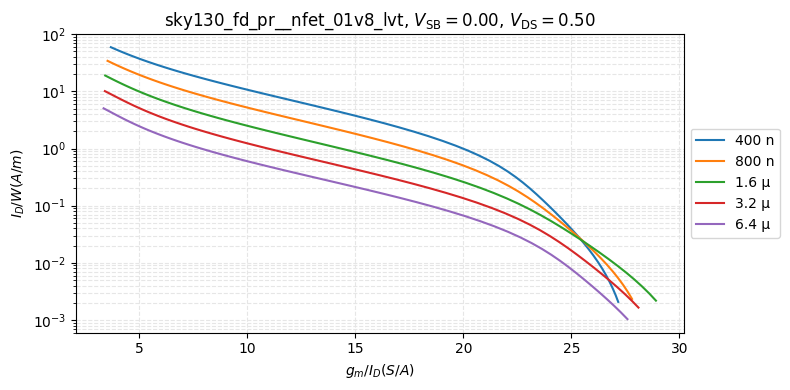

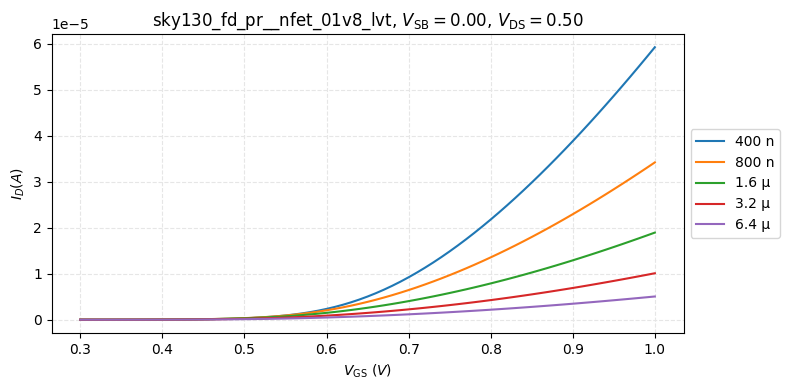

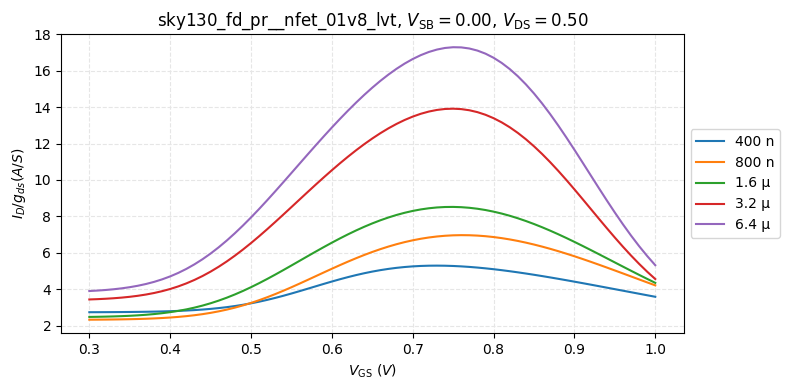

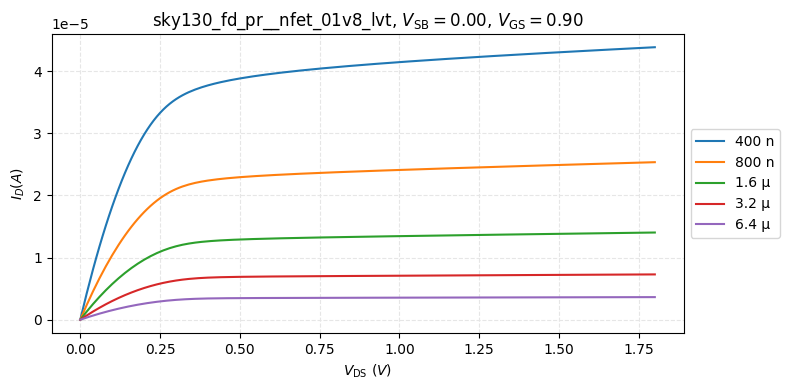

In [7]:
nmos = LoadMosfet(lookup_table=lookup_table, mos="nmos", vsb=0.0, vds=0.5, vgs=(0.3, 1))
nmos.current_density_plot()
nmos.plot_by_expression(
    x_expression = nmos.vgs_expression,
    y_expression = {
        "variables": ["id"],
        "label": "$I_D (A)$"
        },
    y_scale = 'linear'
)
nmos.plot_by_expression(
    x_expression = nmos.vgs_expression,
    y_expression = {
        "variables": ["id", "gds"],
        "function": lambda x, y: x / y,
        "label": "$I_D / g_{ds} (A/S)$"
        }
)
nmos_vgs = LoadMosfet(lookup_table=lookup_table, mos="nmos", vsb=0.0, vds=(0, 1.8), vgs=0.9)
nmos_vgs.plot_by_expression(
    x_expression = nmos_vgs.vds_expression,
    # y_expression = nmos.id_expression, ## same as below
    y_expression = {
        "variables": ["id"],
        "label": "$I_D (A)$"
        },
    y_scale = 'linear'
)

## Curvas caracteristicas para PMOS

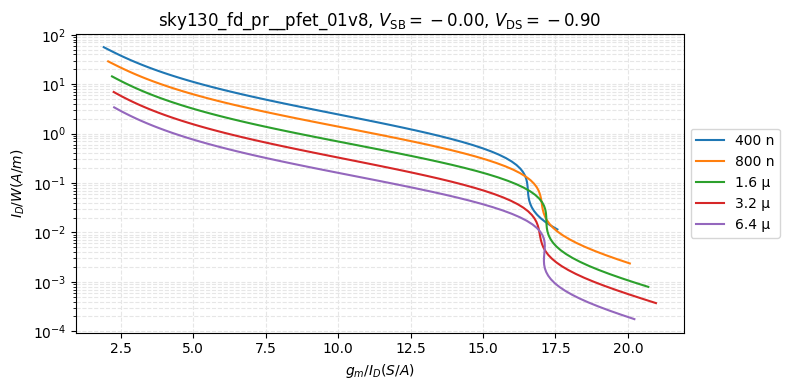

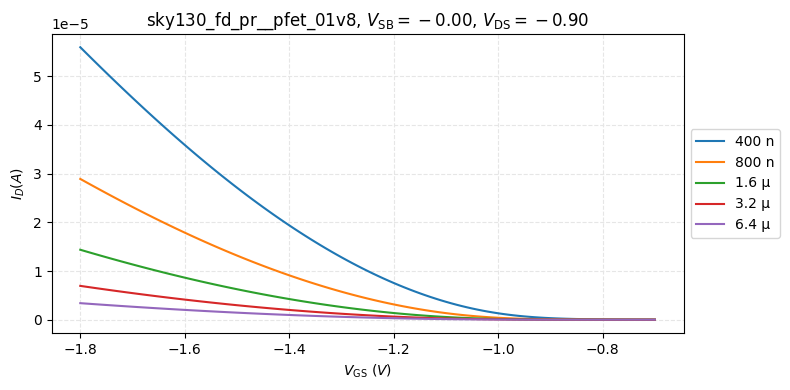

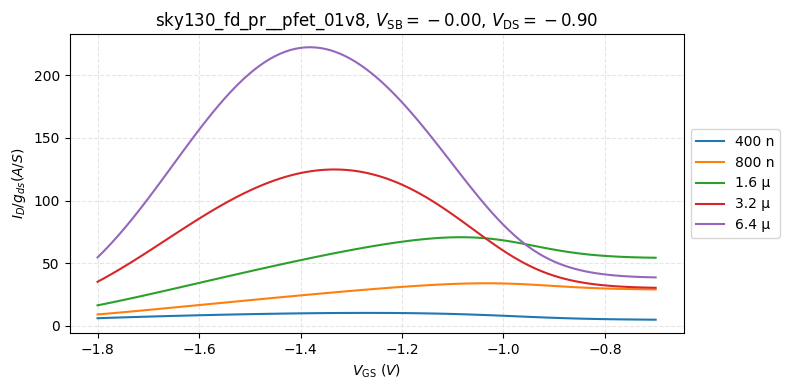

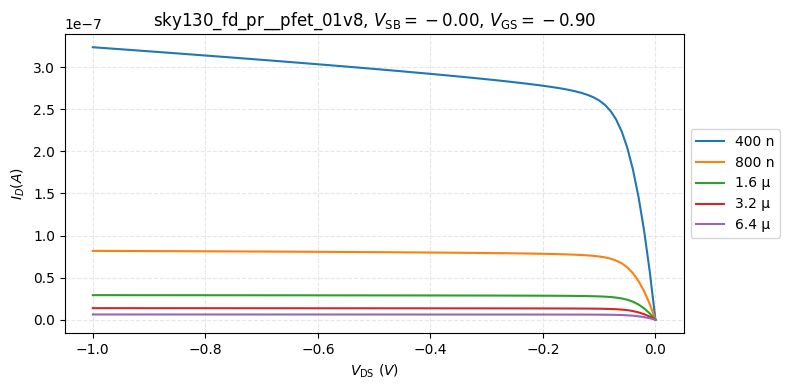

In [326]:
pmos = LoadMosfet(lookup_table=lookup_table, mos="pmos", vsb=0.0, vds=-0.9, vgs=(-1.8, -0.7))
pmos.current_density_plot()
pmos.plot_by_expression(
    x_expression = pmos.vgs_expression,
    # y_expression = nmos.id_expression, ## same as below
    y_expression = {
        "variables": ["id"],
        "label": "$I_D (A)$"
        },
    y_scale = 'linear',
)
pmos.plot_by_expression(
    x_expression = pmos.vgs_expression,
    y_expression = {
        "variables": ["id", "gds"],
        "function": lambda x, y: x / y,
        "label": "$I_D / g_{ds} (A/S)$"
        }
)
pmos_vgs = LoadMosfet(lookup_table=lookup_table, mos="pmos", vsb=0.0, vds=(-1, 0), vgs=-0.9)
pmos_vgs.plot_by_expression(
    x_expression = pmos_vgs.vds_expression,
    # y_expression = nmos.id_expression, ## same as below
    y_expression = {
        "variables": ["id"],
        "label": "$I_D (A)$"
        },
    y_scale = 'linear'
)

# Specs to Device Size based on Razavi

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gmid.mosplot import load_lookup_table, LoadMosfet

lookup_table = load_lookup_table("sky130A_LUT.npy")

### For this part well use the topology shown in the next image:

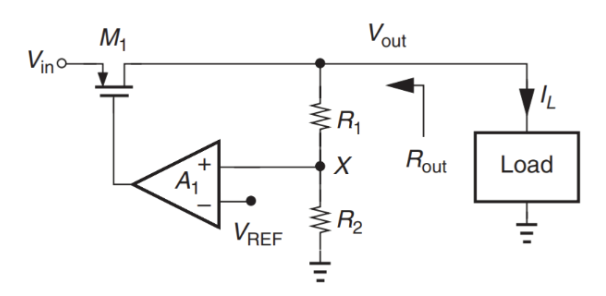

Important equations:

1. $A_{LG}=A_1\cdot g_{m1} \cdot \frac{R2}{R1+R2} \cdot [R2||(R1+R2)]$
2. $\frac{V_{out}}{V_{in}}=\frac{g_{m1}}{1+A_{LG}}\cdot [R_{L}||(R1+R2)]$
3. $R_{out}=(1+\frac{R_1}{R_2})\cdot \frac{1}{g_{m1}A_1}$

In [2]:
Vreg = 1.8
Vdd = 2.2
Vref = 1.2
R1 = 100000
l3 = [0.4e-06, 0.6e-06, 0.8e-06, 1.6e-06]
iq = 0.001
R2 = R1/((Vreg/Vref)-1)
il = 0.001
print(R2)

class Transistor:
    def __init__(self, model= None):
        self.model = model

200000.0


### M_3

1. DoFs = (L, gmid)
2. fixed parameters (due to topology) = (vsb = 0, vds = -(vdd-vreg), id)
3. Dependant variables = (vgs, W, Jd, gm, gds)

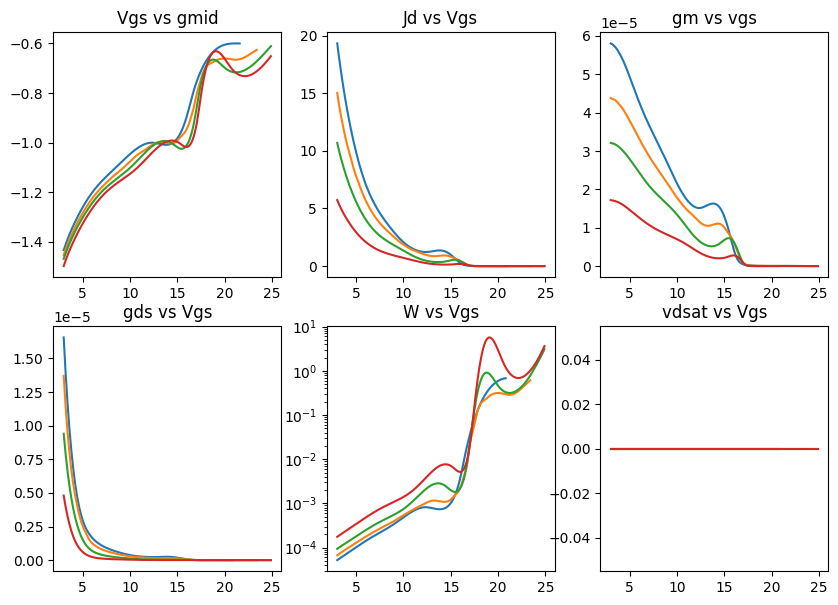

In [26]:
## First create generic mosfet
M_3_table = LoadMosfet(lookup_table=lookup_table, mos="pmos", vsb=0, vds=-(Vdd-Vreg), vgs=(-1.8, -0.6, 0.1), lengths = l3)

## Creacion de transistor
M_3 = Transistor()
gmid_sweep=np.arange(3,25,0.1)

M_3.id = il+Vreg/(R1+R2)

### Vgs con barrido en Gm/id para distintos L
M_3.vgs = M_3_table.interpolate(
            x_expression=M_3_table.lengths_expression,
            x_value=l3,
            y_expression=M_3_table.gmid_expression,
            y_value=gmid_sweep,
            z_expression=M_3_table.vgs_expression,
        )
### Jd con barrido en Vgs para distintos L
M_3.Jd = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.current_density_expression,
            )
    M_3.Jd.append(temp)
M_3.Jd = np.vstack(M_3.Jd)

### Gm con barrido en Vgs para distintos L
M_3.gm = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.gm_expression,
            )
    M_3.gm.append(temp)
M_3.gm = np.vstack(M_3.gm)

M_3.gds = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.gds_expression,
            )
    M_3.gds.append(temp)
M_3.gds = np.vstack(M_3.gds)

M_3.vdsat = []
for idx, x in enumerate(l3):
    temp = M_3_table.interpolate(
                x_expression=M_3_table.lengths_expression,
                x_value=x,
                y_expression=M_3_table.vgs_expression,
                y_value=M_3.vgs[idx,:],
                z_expression=M_3_table.vdsat_expression,
            )
    M_3.vdsat.append(temp)
M_3.vdsat = np.vstack(M_3.vdsat)

M_3.W = np.divide(M_3.id, M_3.Jd)

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
for index, val in enumerate(l3):
    axs[0, 0].plot(gmid_sweep, M_3.vgs[index,:])
axs[0, 0].set_title('Vgs vs gmid')

for index, val in enumerate(l3):
    axs[0, 1].plot(gmid_sweep, M_3.Jd[index,:])
axs[0, 1].set_title('Jd vs Vgs')

for index, val in enumerate(l3):
    axs[0, 2].plot(gmid_sweep, M_3.gm[index,:])
axs[0, 2].set_title('gm vs vgs')

for index, val in enumerate(l3):
    axs[1, 0].plot(gmid_sweep, M_3.gds[index,:])
axs[1, 0].set_title('gds vs Vgs')

for index, val in enumerate(l3):
    axs[1, 1].plot(gmid_sweep, M_3.W[index,:])
axs[1, 1].set_title('W vs Vgs')

for index, val in enumerate(l3):
    axs[1, 2].plot(gmid_sweep, M_3.vdsat[index,:])
axs[1, 2].set_title('vdsat vs Vgs')


#axs[0,0].set_yscale('log')
#axs[0,1].set_yscale('log')
#axs[0,2].set_yscale('log')
#axs[1,0].set_yscale('log')
axs[1,1].set_yscale('log')

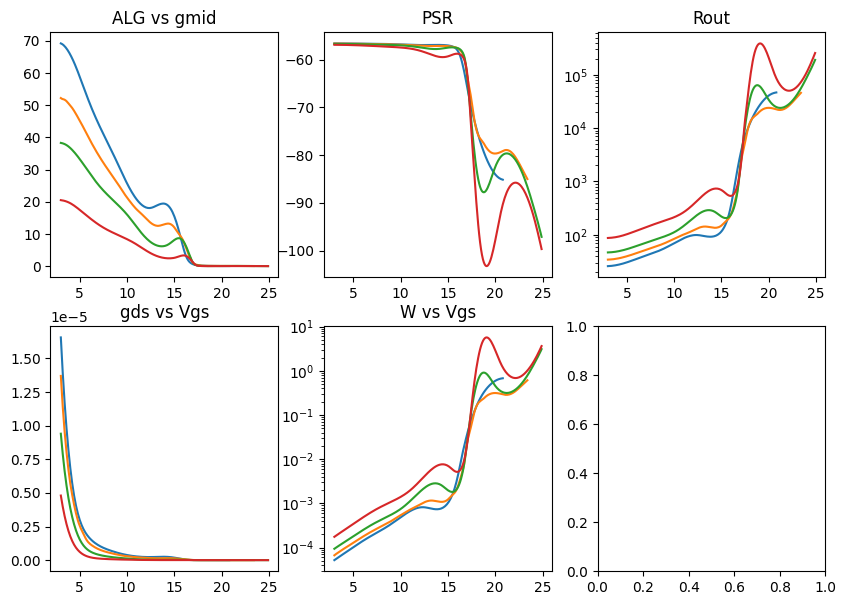

In [7]:
A1 = 1000
RL = Vreg/il
#ALG = np.dot(RL*(R1+R2)/(R1+R2+RL), np.dot(np.dot(A1, M_3.gm), R2/(R1+R2)))

ALG = M_3.gm*A1*R2/(R1+R2)*RL*(R1+R2)/(R1+R2+RL)

"""
print(gmid_sweep[60])
print(M_3.W[1, 60])
print(ALG[1, 60])
print(M_3.gm[1, 60])
print(M_3.vgs[1, 60])
"""

fig, axs = plt.subplots(2, 3, figsize=(10, 7))
for index, val in enumerate(l3):
    axs[0, 0].plot(gmid_sweep, ALG[index,:])
axs[0, 0].set_title("ALG vs gmid")

for index, val in enumerate(l3):
    psr = np.multiply(M_3.gm[index,:], RL*(R1+R2)/((R1+R2+RL)*(1+ALG[index,:])))
    psr_db = 20*np.log10(psr)
    axs[0, 1].plot(gmid_sweep, psr_db)
axs[0, 1].set_title('PSR')

Rout = (1+R1/R2)*np.divide(1,M_3.gm*A1)
for index, val in enumerate(l3):
    axs[0, 2].plot(gmid_sweep, Rout[index,:])
    axs[0, 2].set_yscale("log")
axs[0, 2].set_title('Rout')

for index, val in enumerate(l3):
    axs[1, 0].plot(gmid_sweep, M_3.gds[index,:])
axs[1, 0].set_title('gds vs Vgs')

for index, val in enumerate(l3):
    axs[1, 1].plot(gmid_sweep, M_3.W[index,:])
axs[1, 1].set_title('W vs Vgs')
axs[1,1].set_yscale("log")

## Adding W_0

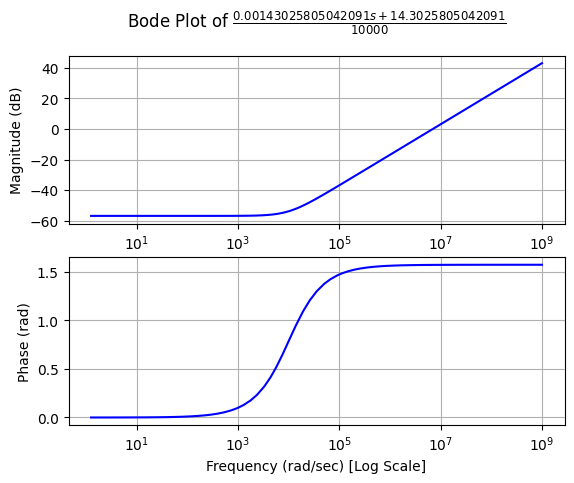

In [22]:
from sympy.physics.control.lti import TransferFunction
from sympy.physics.control.control_plots import bode_plot
import sympy as sym

w0 = 10000

s = sym.Symbol('s')
psr_tf = TransferFunction(psr[0]*(w0+s), w0, s)
bode_plot(psr_tf, initial_exp=0.1, final_exp=9)

### M_2a

1. DoFs = (L, gmid)
2. fixed parameters (due to topology) = (vsb = 0, id = iq/2, Vgs = )
3. Dependant variables = (vgs, W, Jd, gm, gds)

In [212]:
## First create generic mosfet
M_2a_table = LoadMosfet(lookup_table=lookup_table, mos="pmos", vsb=0, vds=(-1.8, 0, 0.1), vgs=(-1.8, -0.6, 0.1), lengths=0.4e-6)

## Creacion de transistor
M_2a = Transistor()

"""
M_2a.vgs = M_2a_table.interpolate(
            x_expression=M_2a_table.vgs_expression,
            x_value=M_2a_table.vgs,
            y_expression=M_2a_table.vds_expression,
            y_value=M_2a_table.vgs,
            z_expression=M_2a_table.vgs_expression,
        )
"""
M_2a.Jd = M_2a_table.interpolate(
            x_expression=M_2a_table.vgs_expression,
            x_value=M_2a_table.vgs,
            y_expression=M_2a_table.vds_expression,
            y_value=M_2a_table.vgs,
            z_expression=M_2a_table.current_density_expression,
        )
M_2a.Jd = np.diag(M_2a.Jd)

M_2a.vgs = M_2a_table.interpolate(
            x_expression=M_2a_table.gmid_expression,
            x_value=[10],
            y_expression=M_2a_table.current_density_expression,
            y_value=M_2a.Jd,
            z_expression=M_2a_table.vgs_expression,
        )

M_2a.gds = M_2a_table.interpolate(
            x_expression=M_2a_table.gmid_expression,
            x_value=10,
            y_expression=M_2a_table.current_density_expression,
            y_value=M_2a.Jd,
            z_expression=M_2a_table.gds_expression,
        )

M_2a.W = np.divide(iq/2,M_2a.Jd)

print(M_2a.vgs)
print(M_2a.Jd)
print(M_2a.W)
M_2a.Jd.shape
#fig, axs = plt.subplots(2, 2, figsize=(10, 7))
#axs[0, 0].plot(M_2a_table.vgs, M_2a.vgs.reshape(M_2a.vgs.shape[1],))
#axs[0, 0].set_title('Vgs vs vds')

[[        nan         nan         nan -0.93627031 -0.94563366 -1.03453432
  -1.03750662 -1.04629072 -1.02253054 -0.89718916 -0.78578236 -0.77903456
  -0.78126087]]
[6.03361436e+01 4.85960773e+01 3.79265918e+01 2.84206162e+01
 2.01664849e+01 1.32476140e+01 7.74618193e+00 3.75149295e+00
 1.33400765e+00 3.18878070e-01 6.09830719e-02 1.10380163e-02
 1.55337165e-03]
[8.28690682e-06 1.02888963e-05 1.31833623e-05 1.75928628e-05
 2.47936119e-05 3.77426455e-05 6.45479289e-05 1.33280272e-04
 3.74810445e-04 1.56799745e-03 8.19899661e-03 4.52979944e-02
 3.21880471e-01]


(13,)

In [217]:
M_2b = LoadMosfet(lookup_table=lookup_table, mos="pmos", vsb=0, vds=(-1.8, 0), vgs=(-1.8, -0.5), lengths=0.4e-6)
M_2b.W = M_2a.W
M_1b = LoadMosfet(lookup_table=lookup_table, mos="nmos", vsb=(0, 1.8, 0.1), vds=Vref, vgs=(0.5, 1.8, 0.1), lengths=0.4e-6)

M_1b.Vd = Vdd + M_2b.vds
M_1b.vgs = M_1b.interpolate(
            x_expression=M_1b.vsb_expression,
            x_value=M_1b.Vd,
            y_expression=M_1b.gmid_expression,
            y_value=10,
            z_expression=M_1b.vgs_expression,
        )
M_1b.Jd = M_1b.interpolate(
            x_expression=M_1b.vgs_expression,
            x_value=M_1b.vgs,
            y_expression=M_1b.vsb_expression,
            y_value=M_1b.vsb,
            z_expression=M_1b.current_density_expression,
        )

M_1b.gm = M_1b.interpolate(
            x_expression=M_1b.vgs_expression,
            x_value=M_1b.vgs,
            y_expression=M_1b.gmid_expression,
            y_value=10,
            z_expression=M_1b.gm_expression,
        )
M_1b.gds = M_1b.interpolate(
            x_expression=M_1b.vgs_expression,
            x_value=M_1b.vgs,
            y_expression=M_1b.gmid_expression,
            y_value=10,
            z_expression=M_1b.gds_expression,
        )

M_1b.W = np.divide(iq/2, M_1b.Jd)

print(M_1b.vgs)
print(M_1b.Jd)
print(M_1b.W)
print(M_1b.Jd.shape)

[[1.10923698]
 [1.10805157]
 [1.1079126 ]
 [1.10807901]
 [1.10826343]
 [1.10817852]
 [1.10753692]
 [1.10605128]
 [1.10343424]
 [1.09939846]
 [1.09365657]
 [1.08988256]
 [1.09010128]
 [1.08983447]
 [1.08931328]
 [1.0882301 ]
 [1.08661642]
 [1.08454262]
 [1.08209959]
 [1.07937819]
 [1.07646929]
 [1.07362902]
 [1.07128205]
 [1.06962536]
 [1.06832247]
 [1.06706124]
 [1.06565543]
 [1.06429349]
 [1.06302977]
 [1.06184695]
 [1.0607277 ]
 [1.05965697]
 [1.05862893]
 [1.05763987]
 [1.05667967]
 [1.05567782]
 [1.05462782]
 [1.0535448 ]
 [1.05242844]
 [1.05124748]
 [1.04996994]
 [1.04866645]
 [1.04741332]
 [1.04619512]
 [1.04504043]
 [1.04398484]
 [1.04291633]
 [1.04167333]
 [1.04030098]
 [1.03882631]
 [1.0371987 ]
 [1.03559111]
 [1.03416676]
 [1.03284812]
 [1.0315723 ]
 [1.03034631]
 [1.02919803]
 [1.0281392 ]
 [1.02692204]
 [1.0255004 ]
 [1.02392843]
 [1.02235895]
 [1.02092835]
 [1.01956692]
 [1.01820248]
 [1.01682864]
 [1.01544736]
 [1.0140684 ]
 [1.01273461]
 [1.01144265]
 [1.00995171]
 [1.00

In [18]:
M_4b = LoadMosfet(lookup_table=lookup_table, mos="nmos", vsb=0, vds=(0, 1.8, 0.2), vgs=(0.5, 1.8, 0.2), lengths=0.4e-6)
M_4b.vds = Vref - M_1b.vgs

M_4b.vgs = M_4b.interpolate(
            x_expression=M_4b.vds_expression,
            x_value=M_4b.vds,
            y_expression=M_4b.gmid_expression,
            y_value=20,
            z_expression=M_4b.vgs_expression,
        )

M_4b.Jd = M_4b.interpolate(
            x_expression=M_4b.vgs_expression,
            x_value=M_4b.vgs,
            y_expression=M_4b.vds_expression,
            y_value=M_4b.vds,
            z_expression=M_4b.current_density_expression,
        )

M_4b.W = np.divide(iq/2, M_4b.Jd)


In [20]:
x = M_3.interpolate(
    x_expression=M_3.current_density_expression,
    x_value=M_3.Jd,
    y_expression=M_3.vgs_expression,
    y_value=M_3.vgs,
    z_expression=M_3.gmid_expression,
    # z_expression=nmos.length_expression,
)
x

array([[           nan,     7.79331851,     8.18391973,     7.21010483,
          -50.65964662,     4.65273878,            nan],
       [           nan,            nan,     9.30273095,    10.17804072,
           13.27854422,    11.91133614, -4520.16012745],
       [           nan,            nan,            nan,    11.96742858,
           12.0456124 ,    12.07895599, -1854.5017062 ],
       [           nan,            nan,            nan,            nan,
           13.91488095,    13.93839173,  -385.90962372],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,  -197.98109336],
       [           nan,            nan,            nan,            nan,
           14.128132  ,            nan,  -285.79129048],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan]])

In [21]:
2/x

array([[        nan,  0.25663009,  0.24438167,  0.27738848, -0.03947915,
         0.42985435,         nan],
       [        nan,         nan,  0.21499063,  0.19650147,  0.15061892,
         0.16790728, -0.00044246],
       [        nan,         nan,         nan,  0.16712028,  0.16603556,
         0.16557722, -0.00107846],
       [        nan,         nan,         nan,         nan,  0.14373102,
         0.14348858, -0.00518256],
       [        nan,         nan,         nan,         nan,         nan,
                nan, -0.01010197],
       [        nan,         nan,         nan,         nan,  0.14156153,
                nan, -0.00699811],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan]])

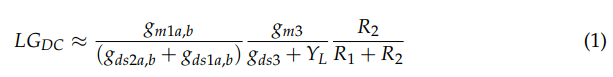

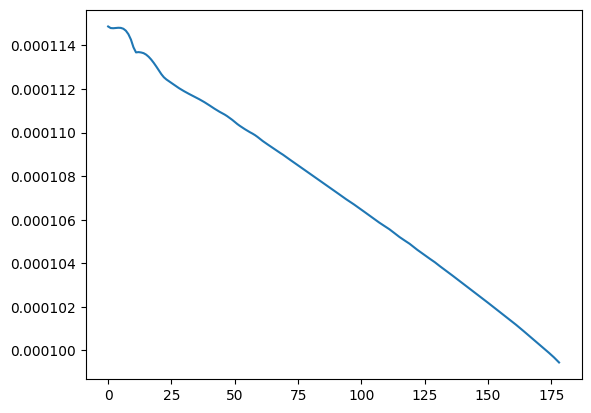

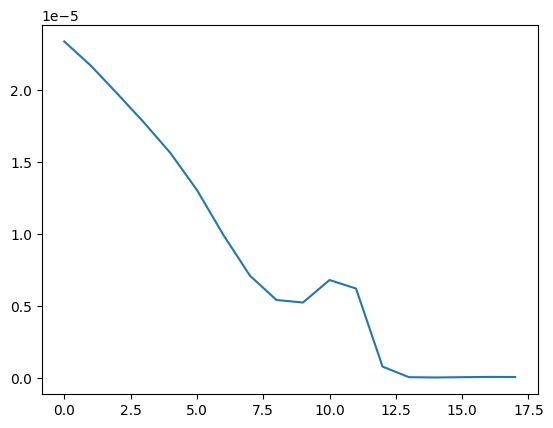

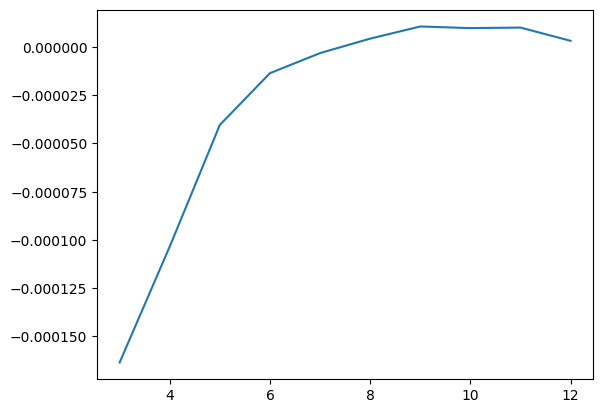

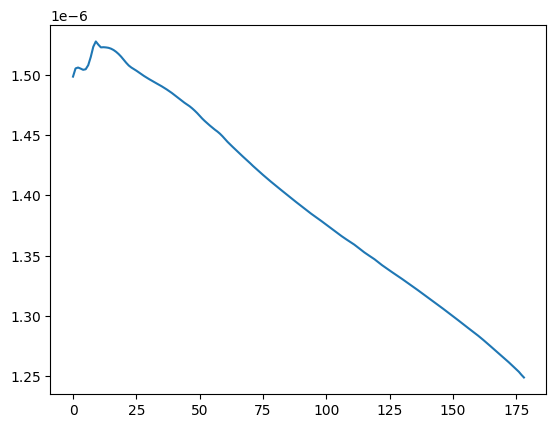

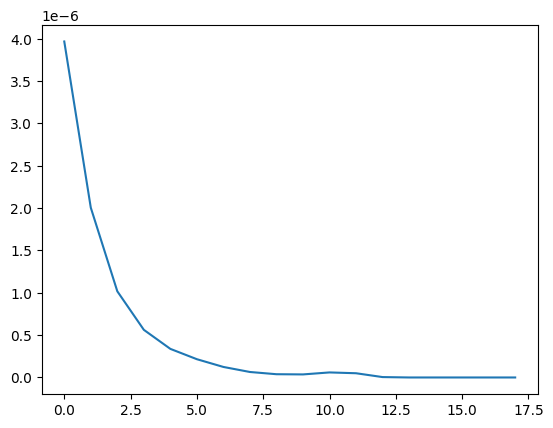

In [221]:
plt.figure()
plt.plot(M_1b.gm)
plt.figure()
plt.plot(M_3.gm.reshape(M_3.gm.shape[1],))
plt.figure()
plt.plot(M_2a.gds.reshape(M_2a.gds.shape[1],))
plt.figure()
plt.plot(M_1b.gds)
plt.figure()
plt.plot(np.transpose(M_3.gds))